In [31]:
# script libraries
import data
# data handling
import pandas as pd
import numpy as np
# machine learning
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Masking, BatchNormalization
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
# from tensorflow.keras.models import Model
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from hist import Hist
import hist
from tqdm import tqdm

## Setup Code

In [32]:
# load in padded dataset
chonky_padded_waveforms = pd.read_parquet('padded_waveforms.parquet')

In [33]:
# us to timesteps
us2timesteps = 100

In [34]:
# finalising the data arrays
padded_array = chonky_padded_waveforms['chonkers'].to_numpy()
x_data = np.stack(padded_array, axis=0)
# divide by max phd
max_phd = x_data.max()
x_data = x_data / max_phd
# set all values less than zero (probs due to noise) to zero. I think this is the correct way to do this?
x_data[x_data < 0] = 0
# waveform intensity range should now be between zero and 1.
print(x_data.min())
print(x_data.max())
print(x_data.shape)
y_data = chonky_padded_waveforms['label'].to_numpy().reshape((-1,1))
print(y_data.shape)
input_length = x_data.shape[-1]
print(input_length)

0.0
1.0
(7782, 3028)
(7782, 1)
3028


In [35]:
# get training and testing sets
runID = chonky_padded_waveforms['runID']
eventID = chonky_padded_waveforms['eventID']
W_array = chonky_padded_waveforms['weights_no_gas'].to_numpy()
X_train, X_test, \
y_train, y_test, \
W_train, W_test, \
runID_train, runID_test, \
eventID_train, eventID_test = \
train_test_split(x_data, y_data, W_array, runID, eventID, random_state=0)
print(X_train.shape)
print(y_train.shape)
print(X_train)
print(y_train)
X_train_reshaped = np.expand_dims(X_train, axis=-1)
print(X_train_reshaped.shape)

print(W_train.shape)

(5836, 3028)
(5836, 1)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[2]
 [2]
 [2]
 ...
 [1]
 [1]
 [1]]
(5836, 3028, 1)
(5836,)


In [36]:
# function to make a cnn

def one_layer_cnn_test(filter_size, num_filters=10, train_iters=20):
    CNN_model = keras.Sequential([
        keras.layers.Conv1D(filters=num_filters,kernel_size=filter_size,activation='relu', input_shape=(input_length, 1)),
        keras.layers.Flatten(),
        keras.layers.Dense(3, activation='softmax')
    ])
    CNN_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(),
                      loss='sparse_categorical_crossentropy',#'binary_crossentropy',
                      metrics=['accuracy'],
                      weighted_metrics=['accuracy'])
    CNN_model.fit(X_train,y_train,epochs=train_iters, validation_split=0.2, shuffle=True, sample_weight=W_train, verbose=0)
    test_loss, test_acc, test_weight_acc = CNN_model.evaluate(X_test,y_test, sample_weight=W_test)
    return test_loss, test_acc, test_weight_acc

def two_layer_cnn_test(filter_size, num_filters=10, train_iters=20):
    CNN_model = keras.Sequential([
        # first layer from previous testing
        keras.layers.Conv1D(filters=6,kernel_size=900,activation='relu', input_shape=(input_length, 1)),
        # second layer for experimentation
        keras.layers.Conv1D(filters=num_filters,kernel_size=filter_size,activation='relu'),
        keras.layers.Flatten(),
        keras.layers.Dense(3, activation='softmax')
    ])
    callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                             patience=3)
    CNN_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0002),
                      loss='sparse_categorical_crossentropy',#'binary_crossentropy',
                      metrics=['accuracy'],
                      weighted_metrics=['accuracy'])
    CNN_model.fit(X_train,y_train,epochs=train_iters, validation_split=0.2, shuffle=True, sample_weight=W_train, verbose=0, callbacks=[callback])
    test_loss, test_acc, test_weight_acc = CNN_model.evaluate(X_test,y_test, sample_weight=W_test)
    return test_loss, test_acc, test_weight_acc

def two_layer_optimising_first_cnn_test(filter_size, num_filters=10, train_iters=25):
    CNN_model = keras.Sequential([
        # first layer from previous testing
        keras.layers.Conv1D(filters=num_filters,kernel_size=filter_size,activation='relu', input_shape=(input_length, 1)),
        # second layer for experimentation
        keras.layers.Conv1D(filters=6,kernel_size=900,activation='relu'),
        keras.layers.Flatten(),
        keras.layers.Dense(3, activation='softmax')
    ])
    callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                             patience=3)
    CNN_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
                      loss='sparse_categorical_crossentropy',#'binary_crossentropy',
                      metrics=['accuracy'],
                      weighted_metrics=['accuracy'])
    CNN_model.fit(X_train,y_train,epochs=train_iters, validation_split=0.2, shuffle=True, sample_weight=W_train, verbose=0, callbacks=[callback])
    test_loss, test_acc, test_weight_acc = CNN_model.evaluate(X_test,y_test, sample_weight=W_test)
    return test_loss, test_acc, test_weight_acc

In [45]:
conv_sizes_layer2 = np.around(np.logspace(-2, 1.3, 30) * us2timesteps)
print(conv_sizes_layer2)
conv_sizes_layer2 = np.delete(conv_sizes_layer2, [1, 3])
print()
print(conv_sizes_layer2)

num_filters_wider_test = 10

loss_list_wider = []
acc_list_wider = []
w_acc_list_wider = []

print('Number of Filters - ' + str(num_filters_wider_test))
for j in tqdm(range(len(conv_sizes_layer2))):
    # loss, acc, w_acc = two_layer_cnn_test(filter_size=int(conv_sizes_layer2[j]),
    #                                       num_filters=int(num_filters_wider_test)
    #                                       )
    loss, acc, w_acc = two_layer_cnn_test(filter_size=int(conv_sizes_layer2[j]),
                                          num_filters=int(num_filters_wider_test)
                                          )
    loss_list_wider.append(loss)
    acc_list_wider.append(acc)
    w_acc_list_wider.append(w_acc)

[1.000e+00 1.000e+00 2.000e+00 2.000e+00 3.000e+00 4.000e+00 5.000e+00
 6.000e+00 8.000e+00 1.100e+01 1.400e+01 1.800e+01 2.300e+01 3.000e+01
 3.900e+01 5.100e+01 6.600e+01 8.600e+01 1.120e+02 1.450e+02 1.890e+02
 2.450e+02 3.190e+02 4.140e+02 5.380e+02 7.000e+02 9.090e+02 1.181e+03
 1.535e+03 1.995e+03]

[1.000e+00 2.000e+00 3.000e+00 4.000e+00 5.000e+00 6.000e+00 8.000e+00
 1.100e+01 1.400e+01 1.800e+01 2.300e+01 3.000e+01 3.900e+01 5.100e+01
 6.600e+01 8.600e+01 1.120e+02 1.450e+02 1.890e+02 2.450e+02 3.190e+02
 4.140e+02 5.380e+02 7.000e+02 9.090e+02 1.181e+03 1.535e+03 1.995e+03]
Number of Filters - 10


  0%|          | 0/28 [00:00<?, ?it/s]

61/61 [==============================] - 1s 18ms/step - loss: 0.0140 - accuracy: 0.8438 - weighted_accuracy: 0.8917


  4%|▎         | 1/28 [01:24<37:55, 84.28s/it]

61/61 [==============================] - 1s 19ms/step - loss: 0.0147 - accuracy: 0.8772 - weighted_accuracy: 0.8818


  7%|▋         | 2/28 [02:43<35:20, 81.54s/it]

61/61 [==============================] - 1s 18ms/step - loss: 0.0127 - accuracy: 0.8571 - weighted_accuracy: 0.8981


 11%|█         | 3/28 [04:03<33:34, 80.57s/it]

61/61 [==============================] - 1s 17ms/step - loss: 0.0135 - accuracy: 0.8561 - weighted_accuracy: 0.8872


 14%|█▍        | 4/28 [05:22<31:57, 79.89s/it]

61/61 [==============================] - 1s 18ms/step - loss: 0.0130 - accuracy: 0.8577 - weighted_accuracy: 0.8958


 18%|█▊        | 5/28 [06:43<30:45, 80.25s/it]

61/61 [==============================] - 1s 23ms/step - loss: 0.0137 - accuracy: 0.8772 - weighted_accuracy: 0.8827


 21%|██▏       | 6/28 [08:02<29:21, 80.08s/it]

61/61 [==============================] - 1s 20ms/step - loss: 0.0146 - accuracy: 0.8582 - weighted_accuracy: 0.8882


 25%|██▌       | 7/28 [09:21<27:50, 79.57s/it]

61/61 [==============================] - 1s 20ms/step - loss: 0.0142 - accuracy: 0.8828 - weighted_accuracy: 0.8888


 29%|██▊       | 8/28 [10:39<26:22, 79.13s/it]

61/61 [==============================] - 1s 19ms/step - loss: 0.0155 - accuracy: 0.8505 - weighted_accuracy: 0.8942


 32%|███▏      | 9/28 [11:57<24:58, 78.86s/it]

61/61 [==============================] - 1s 19ms/step - loss: 0.0149 - accuracy: 0.8659 - weighted_accuracy: 0.8715


 36%|███▌      | 10/28 [13:15<23:33, 78.53s/it]

61/61 [==============================] - 1s 19ms/step - loss: 0.0155 - accuracy: 0.8582 - weighted_accuracy: 0.8959


 39%|███▉      | 11/28 [14:33<22:14, 78.48s/it]

61/61 [==============================] - 1s 20ms/step - loss: 0.0148 - accuracy: 0.8556 - weighted_accuracy: 0.8918


 43%|████▎     | 12/28 [15:53<21:03, 78.96s/it]

61/61 [==============================] - 1s 19ms/step - loss: 0.0117 - accuracy: 0.8736 - weighted_accuracy: 0.8881


 46%|████▋     | 13/28 [17:15<19:57, 79.82s/it]

61/61 [==============================] - 1s 20ms/step - loss: 0.0135 - accuracy: 0.8767 - weighted_accuracy: 0.8969


 50%|█████     | 14/28 [18:40<18:57, 81.23s/it]

61/61 [==============================] - 1s 17ms/step - loss: 0.0136 - accuracy: 0.8510 - weighted_accuracy: 0.8941


 54%|█████▎    | 15/28 [20:06<17:54, 82.67s/it]

61/61 [==============================] - 1s 19ms/step - loss: 0.0134 - accuracy: 0.8839 - weighted_accuracy: 0.8837


 57%|█████▋    | 16/28 [21:37<17:02, 85.18s/it]

61/61 [==============================] - 1s 21ms/step - loss: 0.0121 - accuracy: 0.8582 - weighted_accuracy: 0.8896


 61%|██████    | 17/28 [23:16<16:24, 89.49s/it]

61/61 [==============================] - 1s 20ms/step - loss: 0.0159 - accuracy: 0.8268 - weighted_accuracy: 0.8572


 64%|██████▍   | 18/28 [25:00<15:36, 93.70s/it]

61/61 [==============================] - 1s 19ms/step - loss: 0.0136 - accuracy: 0.8654 - weighted_accuracy: 0.8947


 68%|██████▊   | 19/28 [26:55<15:00, 100.10s/it]

61/61 [==============================] - 1s 22ms/step - loss: 0.0138 - accuracy: 0.8710 - weighted_accuracy: 0.8906


 71%|███████▏  | 20/28 [28:58<14:16, 107.09s/it]

61/61 [==============================] - 1s 24ms/step - loss: 0.0147 - accuracy: 0.8762 - weighted_accuracy: 0.8972


 75%|███████▌  | 21/28 [31:23<13:48, 118.36s/it]

61/61 [==============================] - 1s 21ms/step - loss: 0.0121 - accuracy: 0.8577 - weighted_accuracy: 0.8995


 79%|███████▊  | 22/28 [33:58<12:55, 129.26s/it]

61/61 [==============================] - 1s 22ms/step - loss: 0.0123 - accuracy: 0.8587 - weighted_accuracy: 0.8947


 82%|████████▏ | 23/28 [36:50<11:51, 142.36s/it]

61/61 [==============================] - 1s 22ms/step - loss: 0.0117 - accuracy: 0.8417 - weighted_accuracy: 0.8921


 86%|████████▌ | 24/28 [40:03<10:29, 157.48s/it]

61/61 [==============================] - 2s 25ms/step - loss: 0.0125 - accuracy: 0.8535 - weighted_accuracy: 0.8943


 89%|████████▉ | 25/28 [43:45<08:50, 176.89s/it]

61/61 [==============================] - 2s 28ms/step - loss: 0.0125 - accuracy: 0.8325 - weighted_accuracy: 0.8919


 93%|█████████▎| 26/28 [47:58<06:39, 199.61s/it]

61/61 [==============================] - 1s 23ms/step - loss: 0.0114 - accuracy: 0.8607 - weighted_accuracy: 0.8988


 96%|█████████▋| 27/28 [52:07<03:34, 214.51s/it]

61/61 [==============================] - 1s 17ms/step - loss: 0.0119 - accuracy: 0.8720 - weighted_accuracy: 0.8939


100%|██████████| 28/28 [56:15<00:00, 120.55s/it]


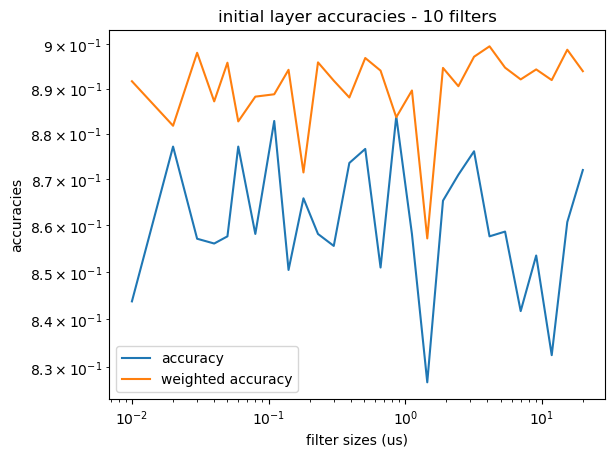

In [46]:
plt.figure()
plt.loglog(conv_sizes_layer2 / us2timesteps, acc_list_wider, label='accuracy')
plt.loglog(conv_sizes_layer2 / us2timesteps, w_acc_list_wider, label='weighted accuracy')
plt.xlabel('filter sizes (us)')
plt.ylabel('accuracies')
plt.title('initial layer accuracies - 10 filters')
# plt.xscale='log'
# plt.yscale='log'
plt.legend()

In [47]:
w_acc_array = np.array(w_acc_list_wider)


# print('best num filters - ' + str(np.where(w_acc_array==w_acc_array.max())))
print('Num Filters - ' + str(num_filters_wider_test))
print('max weighted accuracy - ' + str(w_acc_array.max()))
# print(w_accs0to4.max())
# print(w_accs6to8.max())
# print(np.where(w_accs0to4==w_accs0to4.max())[1][0])
print('best filter size - ' + str(conv_sizes_layer2[np.where(w_acc_array==w_acc_array.max())] / us2timesteps) + 'us')
# print(np.where(w_accs6to8==w_accs6to8.max()))
print()

Num Filters - 10
max weighted accuracy - 0.8995243906974792
best filter size - [4.14]us



## Trying many filters for an 319 timestep second layer (900 timestep 6 filter first layer)

In [48]:
# testing number of convolutions

num_filters_big_range = np.around(np.logspace(0, 3, 25))[:21]
num_filters_big_range = np.delete(num_filters_big_range, [1, 3])
conv_size_big_range = 319

loss_list_big_range = []
acc_list_big_range = []
w_acc_list_big_range = []

print('Number of Filters - ' + str(num_filters_big_range))
for j in tqdm(range(len(num_filters_big_range))):
    loss, acc, w_acc = two_layer_cnn_test(filter_size=int(conv_size_big_range),
                                          num_filters=int(num_filters_big_range[j])
                                          )
    loss_list_big_range.append(loss)
    acc_list_big_range.append(acc)
    w_acc_list_big_range.append(w_acc)

Number of Filters - [  1.   2.   3.   4.   6.   7.  10.  13.  18.  24.  32.  42.  56.  75.
 100. 133. 178. 237. 316.]


  0%|          | 0/19 [00:00<?, ?it/s]

61/61 [==============================] - 1s 21ms/step - loss: 0.0136 - accuracy: 0.8633 - weighted_accuracy: 0.8987


  5%|▌         | 1/19 [01:49<32:54, 109.71s/it]

61/61 [==============================] - 1s 23ms/step - loss: 0.0151 - accuracy: 0.8582 - weighted_accuracy: 0.8939


 11%|█         | 2/19 [03:23<28:22, 100.12s/it]

61/61 [==============================] - 1s 22ms/step - loss: 0.0152 - accuracy: 0.8376 - weighted_accuracy: 0.8922


 16%|█▌        | 3/19 [05:00<26:18, 98.68s/it] 

61/61 [==============================] - 1s 21ms/step - loss: 0.0153 - accuracy: 0.8633 - weighted_accuracy: 0.8929


 21%|██        | 4/19 [06:35<24:22, 97.53s/it]

61/61 [==============================] - 1s 21ms/step - loss: 0.0142 - accuracy: 0.8839 - weighted_accuracy: 0.8773


 26%|██▋       | 5/19 [08:22<23:30, 100.76s/it]

61/61 [==============================] - 1s 21ms/step - loss: 0.0157 - accuracy: 0.8037 - weighted_accuracy: 0.8816


 32%|███▏      | 6/19 [10:32<23:59, 110.76s/it]

61/61 [==============================] - 1s 23ms/step - loss: 0.0131 - accuracy: 0.8520 - weighted_accuracy: 0.8959


 37%|███▋      | 7/19 [12:57<24:25, 122.11s/it]

61/61 [==============================] - 2s 25ms/step - loss: 0.0148 - accuracy: 0.8700 - weighted_accuracy: 0.8727


 42%|████▏     | 8/19 [16:40<28:16, 154.18s/it]

61/61 [==============================] - 2s 29ms/step - loss: 0.0121 - accuracy: 0.8607 - weighted_accuracy: 0.8975


 47%|████▋     | 9/19 [20:39<30:06, 180.69s/it]

61/61 [==============================] - 2s 26ms/step - loss: 0.0121 - accuracy: 0.8613 - weighted_accuracy: 0.8972


 53%|█████▎    | 10/19 [24:50<30:20, 202.25s/it]

61/61 [==============================] - 2s 26ms/step - loss: 0.0134 - accuracy: 0.8078 - weighted_accuracy: 0.8742


 58%|█████▊    | 11/19 [28:18<27:11, 203.92s/it]

61/61 [==============================] - 2s 40ms/step - loss: 0.0132 - accuracy: 0.8124 - weighted_accuracy: 0.8833


 63%|██████▎   | 12/19 [35:12<31:16, 268.02s/it]

61/61 [==============================] - 2s 35ms/step - loss: 0.0119 - accuracy: 0.8649 - weighted_accuracy: 0.8871


 68%|██████▊   | 13/19 [42:49<32:31, 325.31s/it]

61/61 [==============================] - 5s 77ms/step - loss: 0.0125 - accuracy: 0.8772 - weighted_accuracy: 0.8881


 74%|███████▎  | 14/19 [55:48<38:31, 462.32s/it]

61/61 [==============================] - 4s 59ms/step - loss: 0.0116 - accuracy: 0.8705 - weighted_accuracy: 0.8925


 79%|███████▉  | 15/19 [2:36:59<2:23:31, 2152.85s/it]

61/61 [==============================] - 8s 126ms/step - loss: 0.0117 - accuracy: 0.8628 - weighted_accuracy: 0.8995


 84%|████████▍ | 16/19 [2:58:57<1:35:04, 1901.51s/it]

61/61 [==============================] - 7s 118ms/step - loss: 0.0120 - accuracy: 0.8643 - weighted_accuracy: 0.8859


 89%|████████▉ | 17/19 [3:27:08<1:01:16, 1838.39s/it]

61/61 [==============================] - 14s 231ms/step - loss: 0.0115 - accuracy: 0.8782 - weighted_accuracy: 0.8887


 95%|█████████▍| 18/19 [4:13:50<35:27, 2127.85s/it]  

61/61 [==============================] - 9s 146ms/step - loss: 0.0118 - accuracy: 0.8746 - weighted_accuracy: 0.8920


100%|██████████| 19/19 [4:56:32<00:00, 936.45s/it] 


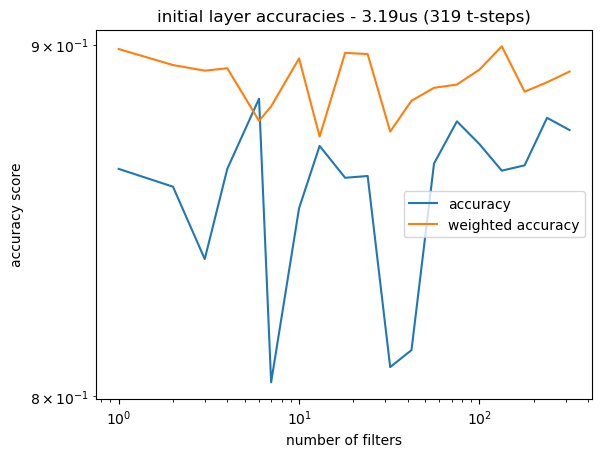

In [50]:
plt.figure()
plt.loglog(num_filters_big_range[:len(acc_list_big_range)], acc_list_big_range, label='accuracy')
plt.loglog(num_filters_big_range[:len(w_acc_list_big_range)], w_acc_list_big_range, label='weighted accuracy')
plt.xlabel('number of filters')
plt.ylabel('accuracy score')
plt.title('initial layer accuracies - 3.19us (319 t-steps)')
# plt.xscale='log'
# plt.yscale='log'
plt.legend()